In [7]:
import pandas as pd
import numpy as np
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, MaxPool2D, CuDNNGRU, GlobalMaxPool2D, Reshape, \
concatenate, Input, TimeDistributed, Dense, BatchNormalization, SpatialDropout2D, SpatialDropout1D, Dropout, GlobalAvgPool2D, Flatten
from keras import Model
from keras.applications import Xception
import keras.backend as k
from sklearn.model_selection import train_test_split

[2.2606]
20400


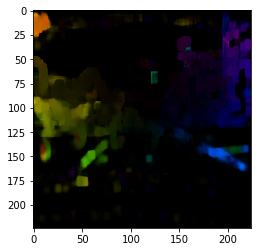

In [8]:
hdf5_path = './train_data/train.hdf5'
with h5py.File(hdf5_path, "r") as f:
    plt.imshow(f["frame"][20398])
    plt.imshow(f["op_flow"][20398])
    print(f['speed'][20398])
    print(len(f["speed"]))

In [9]:
with h5py.File(hdf5_path, "r") as f:
    print(f["frame"][20398].max())
    print(f["op_flow"][20398].max())
    print(f['speed'][20398])
    print(len(f["speed"]))
    train_size = len(f["speed"])

1.0
0.9853942
[2.2606]
20400


In [10]:
from sklearn.utils import shuffle

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, history_size, hdf5_path, indexes):
        self.hdf5_path = hdf5_path
        if indexes is None:
            with h5py.File(hdf5_path, "r") as f:
                self.indexes = np.arange(len(f["speed"]))
        else:
            self.indexes = indexes
        self.batch_size = batch_size
        self.history_size = history_size
        self.on_epoch_end()
        with h5py.File(hdf5_path, "r") as f:
            self.frame = np.array(f["frame"])[self.indexes]
            self.op_flow = np.array(f["op_flow"])[self.indexes]
            self.speed = np.array(f["speed"])[self.indexes]
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        frame = np.zeros((self.batch_size, self.history_size, 224, 224, 3))
        op_flow = np.zeros((self.batch_size, self.history_size, 224, 224, 3))
        speed = np.zeros((self.batch_size, 1))
        frame_order = list(range(self.history_size))
        frame_pos = np.zeros(shape = (self.batch_size, self.history_size))
        for pos, i in enumerate(indexes):
            time_steps = self.frame[i - self.history_size: i].shape[0]
            if time_steps < self.history_size:
                frame[pos, -1] = self.frame[i]
                op_flow[pos, -1] = self.op_flow[i]
                frame_pos[pos] = np.array(list(range(self.history_size)))
            else:
                if np.random.random() > .5:
                    frame_order_pos = np.array([0,1,2,3,4])
                else:
                    frame_order_pos = np.array([4,1,2,3,0])
                frame[pos, frame_order_pos] = self.frame[i - self.history_size:i]
                op_flow[pos, frame_order_pos] = self.op_flow[i - self.history_size:i]
                frame_pos[pos] = frame_order_pos
            speed[pos] = self.speed[i]
        return [frame, op_flow], frame_pos

In [11]:
# train_indexes, val_indexes = train_test_split(np.arange(int(train_size)), shuffle = False, test_size = .01)
train_indexes = np.arange(int(train_size))

In [12]:
time_history = 5
train_generator = DataGenerator(16, time_history, hdf5_path, indexes = train_indexes)
# valid_generator = DataGenerator(16, time_history, hdf5_path, indexes = val_indexes)

In [13]:
def build_model(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(SpatialDropout2D(.2))(frame_inp)
    frame = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(16, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    #frame = TimeDistributed(SpatialDropout2D(.2))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([frame_max, frame_avg])
    #conc = BatchNormalization()(conc)
    conc = SpatialDropout1D(.2)(conc)
    conc = Flatten()(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(history_size)(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [14]:
model = build_model(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 224, 224,  0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 222, 222,  224         time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 5, 111, 111,  0           time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [16]:
hist = model.fit_generator(train_generator, epochs = 10)

Epoch 1/10
1275/1275 [==============================] - 257s 201ms/step - loss: 1.6241
Epoch 2/10
1275/1275 [==============================] - 256s 201ms/step - loss: 1.6175
Epoch 3/10
1275/1275 [==============================] - 256s 201ms/step - loss: 1.6135
Epoch 4/10
1275/1275 [==============================] - 258s 202ms/step - loss: 1.6130
Epoch 5/10
1275/1275 [==============================] - 257s 202ms/step - loss: 1.6098
Epoch 6/10
 891/1275 [===================>..........] - ETA: 1:17 - loss: 1.6085

KeyboardInterrupt: 

In [ ]:
model.save("ordered_model.h5")

In [ ]:
predictions = model.predict_generator(train_generator)

In [ ]:
predictions[1]

In [12]:
model.load_weights("ordered_model.h5")

In [ ]:
def build_model_flat(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(SpatialDropout2D(.2))(frame_inp)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(16, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    #frame = TimeDistributed(SpatialDropout2D(.2))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(GlobalMaxPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([op_flow_max, op_flow_avg])
    #conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(50, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [ ]:
model_flat = build_model_flat(time_history)

In [19]:
hist2 = model_flat.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 159s 156ms/step - loss: 35.8948 - val_loss: 11.0542
Epoch 2/10
1020/1020 [==============================] - 157s 154ms/step - loss: 15.0197 - val_loss: 9.4156
Epoch 3/10
1020/1020 [==============================] - 157s 154ms/step - loss: 10.0102 - val_loss: 8.5197
Epoch 4/10
1020/1020 [==============================] - 157s 154ms/step - loss: 7.9395 - val_loss: 8.5695
Epoch 5/10
1020/1020 [==============================] - 158s 155ms/step - loss: 6.7795 - val_loss: 6.8394
Epoch 6/10
1020/1020 [==============================] - 157s 154ms/step - loss: 6.0563 - val_loss: 7.4881
Epoch 7/10
1020/1020 [==============================] - 158s 155ms/step - loss: 5.5539 - val_loss: 9.5486
Epoch 8/10
1020/1020 [==============================] - 157s 154ms/step - loss: 4.9920 - val_loss: 6.6580
Epoch 9/10
1020/1020 [==============================] - 159s 156ms/step - loss: 4.7369 - val_loss: 6.8002
Epoch 10/10
1020/1020 [===================

In [53]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        #frame_max, frame_avg,
        op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [54]:
model3 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 3, 224, 224,  12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 3, 224, 224,  0           time_distributed_6[0][0]         
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 3, 222, 222,  112         time_distributed_7[0][0]         
__________________________________________________________________________________________________
time_distr

In [55]:
hist3 = model3.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 163s 159ms/step - loss: 28.2054 - val_loss: 12.9030
Epoch 2/10
1020/1020 [==============================] - 160s 157ms/step - loss: 13.6002 - val_loss: 18.9242
Epoch 3/10
1020/1020 [==============================] - 158s 155ms/step - loss: 10.7904 - val_loss: 11.0065
Epoch 4/10
1020/1020 [==============================] - 159s 156ms/step - loss: 8.6554 - val_loss: 13.5720
Epoch 5/10
1020/1020 [==============================] - 160s 156ms/step - loss: 7.8862 - val_loss: 5.3888
Epoch 6/10
1020/1020 [==============================] - 161s 157ms/step - loss: 6.3103 - val_loss: 7.8890
Epoch 7/10
1020/1020 [==============================] - 160s 157ms/step - loss: 5.9375 - val_loss: 7.0740
Epoch 8/10
1020/1020 [==============================] - 160s 156ms/step - loss: 5.4968 - val_loss: 9.8594
Epoch 9/10
1020/1020 [==============================] - 160s 157ms/step - loss: 4.8999 - val_loss: 8.6684
Epoch 10/10
1020/1020 [================

In [56]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        frame_max, frame_avg,
        #op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [57]:
model4 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 224, 224,  12          input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 3, 7, 7, 2048 20861480    time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 3, 7, 7, 128) 262272      time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [ ]:
hist4 = model4.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 467s 457ms/step - loss: 13.3131 - val_loss: 69.9541
Epoch 2/10
1020/1020 [==============================] - 463s 454ms/step - loss: 6.5272 - val_loss: 54.6221
Epoch 3/10
 578/1020 [================>.............] - ETA: 2:56 - loss: 5.8293